# Ultimatum game

## Init and import

In [1]:
# !pip install git+https://github.com/google-deepmind/concordia.git

In [2]:
# !pip install sentence_transformers

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime

import numpy as np
import sentence_transformers

# from google.colab import widgets  # pytype: disable=import-error
from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.language_model import gpt_model
# from concordia.language_model import gcloud_model
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [156]:
# Setup sentence encoder
st_model = sentence_transformers.SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embedder = lambda x: st_model.encode(x, show_progress_bar=False)


In [134]:
# @title Language Model - pick your model and provide keys
import os


from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  # read local .env file

GPT_API_KEY = os.environ.get("GPT_API_KEY")

GPT_MODEL_NAME = 'gpt-3.5-turbo-16k'


USE_CLOUD = False #@param {type: 'boolean'}

# if USE_CLOUD:
  # model = gcloud_model.CloudLanguageModel(project_id= CLOUD_PROJECT_ID)
# else:
model = gpt_model.GptLanguageModel(api_key=GPT_API_KEY, model_name=GPT_MODEL_NAME)

In [135]:
GPT_MODEL_NAME

'gpt-3.5-turbo-16k'

## Configuring the generic knowledge of players and GM.

In [157]:
#@title Make the clock
TIME_STEP = datetime.timedelta(hours=1)
SETUP_TIME = datetime.datetime(hour=9, year=2024, month=7, day=1)

START_TIME = datetime.datetime(hour=10, year=2024, month=7, day=1)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[TIME_STEP, datetime.timedelta(seconds=10)])


In [158]:
#@title Importance models
importance_model = importance_function.AgentImportanceModel(model)
importance_model_gm = importance_function.ConstantImportanceModel()


In [159]:
# Shared memories for the Finetown scenario

shared_memories = [
    'Finetown is a small town.',
    'There is a cafe in Finetown called The Blue Rose.',
    'Each hour two players meet at The Blue Rose to drink a cup of coffee and play one round of the Ultimatum Game.',
    'The Ultimatum Game is a game in which one player proposes a division of a fixed sum of money, and the other player decides whether to accept or reject the offer.',
    'If the offer is accepted, both players receive the proposed amounts. If the offer is rejected, neither player receives any money.',
    'Each hour, a fixed sum (e.g., $10) will be proposed by one player, who will then consider the split. The receiving player will then decide whether to accept or reject the offer.'
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


In the small town of Finetown, there is a cafe called The Blue Rose where two players meet every hour to play the Ultimatum Game. In this game, one player proposes a division of a fixed sum of money, and the other player decides whether to accept or reject the offer. If the offer is accepted, both players receive the proposed amounts, but if it is rejected, neither player receives any money.


## Configure and build the players



In [160]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

## Functions to build the players

In [161]:
def build_agent(agent_config,
                player_names: list[str],
                measurements: measurements_lib.Measurements | None = None):

  mem = formative_memory_factory.make_memories(agent_config)

  time = generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
  )

  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )

  self_perception = components.self_perception.SelfPerception(
      name=f'What kind of person is {agent_config.name}? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name=f'What kind of situation is {agent_config.name} in right now? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[current_obs],
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name=(f'What would a person like {agent_config.name} do in a situation ' +
            'like this? '),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
  )

  initial_goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal)
  plan = components.plan.SimPlan(
      model,
      mem,
      agent_config.name,
      clock_now=clock.now,
      components=[initial_goal_component, person_by_situation],
      goal=person_by_situation,
      timescale='the next hour',
      time_adverb='detailed',
      verbose=False,
  )

  persona = generic_components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
          plan,
      ]
  )

  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      components=[persona, current_obs],
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      component_name='summary of observations',
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )
  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[persona,
                  summary_obs,
                  current_obs,
                  time,
                  goal_metric,
                  morality_metric],
      update_interval = TIME_STEP
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question='What is {opining_player}\'s opinion of {of_player}?',
  )
  agent.add_component(reputation_metric)
  return agent


## Configure and build the players

In [164]:
import random

# Function to generate random Big Five personality traits
def make_random_big_five() -> str:
    return str({
        'extraversion': random.randint(1, 10),
        'neuroticism': random.randint(1, 10),
        'openness': random.randint(1, 10),
        'conscientiousness': random.randint(1, 10),
        'agreeableness': random.randint(1, 10),
    })

NUM_PLAYERS = 2

names_and_genders = [
    ('Alice', 'female', 'Alice works as a librarian and enjoys reading and gardening.'),
    ('Bob', 'male', 'Bob is a software developer who likes coding and hiking.'),
    ('Charlie', 'male', 'Charlie is a chef who loves cooking and playing soccer.'),
    ('Dana', 'female', 'Dana is a nurse who enjoys painting and running.'),
    ('Eve', 'female', 'Eve is a graphic designer who likes drawing and cycling.'),
    ('Frank', 'male', 'Frank is a teacher who enjoys teaching and playing chess.'),
]

selected_players = random.sample(names_and_genders, NUM_PLAYERS)

# Create player configurations
player_configs = [
    formative_memories.AgentConfig(
        name=selected_players[0][0],
        gender=selected_players[0][1],
        goal=f'{selected_players[0][0]} wants to get the maximum possible money from the Ultimatum Game.',
        context=f'{selected_players[0][2]}. {selected_players[0][0]} want to get out of game as much money as possible.',
        traits=make_random_big_five(),
        extras={'initial_endowment': {'money': 0},},
    ),
    formative_memories.AgentConfig(
        name=selected_players[1][0],
        gender=selected_players[1][1],
        goal=f'{selected_players[1][0]} wants to get the maximum possible money from the Ultimatum Game.',
        context=f'{selected_players[1][2]}. {selected_players[1][0]} want to get out of game as much money as possible.',
        traits=make_random_big_five(),
        extras={'initial_endowment': {'money': 0},},
    )
]

# Print the player configurations for verification
for config in player_configs:
    print(config)




AgentConfig(name='Eve', gender='female', traits="{'extraversion': 8, 'neuroticism': 10, 'openness': 6, 'conscientiousness': 6, 'agreeableness': 1}", context='Eve is a graphic designer who likes drawing and cycling.. Eve want to get out of game as much money as possible.', specific_memories='', goal='Eve wants to get the maximum possible money from the Ultimatum Game.', date_of_birth=datetime.datetime(1984, 7, 3, 0, 0), formative_ages=(6, 9, 13, 16, 21), formative_memory_importance=1.0, extras={'initial_endowment': {'money': 0}})
AgentConfig(name='Charlie', gender='male', traits="{'extraversion': 8, 'neuroticism': 9, 'openness': 1, 'conscientiousness': 3, 'agreeableness': 1}", context='Charlie is a chef who loves cooking and playing soccer.. Charlie want to get out of game as much money as possible.', specific_memories='', goal='Charlie wants to get the maximum possible money from the Ultimatum Game.', date_of_birth=datetime.datetime(1984, 7, 3, 0, 0), formative_ages=(6, 9, 13, 16, 21),

In [165]:
import time

from openai import RateLimitError

# Function to build an agent with retry on rate limit error
def build_agent_with_retry(config, player_names, measurements):
    while True:
        try:
            return build_agent(config, player_names, measurements)
        except RateLimitError as e:
            print(f"Rate limit exceeded: {e}. Retrying after a short delay...")
            time.sleep(5)  # Wait for 5 seconds before retrying

# Initialize the players using a ThreadPoolExecutor with retry mechanism
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []
pl_memories = {}
ult_memories = {}
money = {}

for pl_config in player_configs:
    players.append(build_agent(pl_config,player_names,measurements))

# with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
#     for agent in pool.map(build_agent,
#                                player_configs[:NUM_PLAYERS],
#                                [player_names] * NUM_PLAYERS,
#                                [measurements] * NUM_PLAYERS):
#         players.append(agent)
#         # pl_memories[agent.name] = mem.copy()


# Print the players for verification
for player in players:
    money[player.name] = 0
    ult_memories[player.name] = []
    print(player)

Number of generated formative episodes (1) does not match number of formative ages (5).


Memories of Eve:
[03 Jul 1990 00:00:00] When Eve was 6 years old, they experienced their first day of school. As an outgoing and vibrant child, Eve eagerly made friends and charmed their classmates and teachers. However, their high level of neuroticism made them anxious about fitting in and being liked by everyone.

When Eve was 9 years old, they participated in a school art competition. Their passion for art and design was evident in their intricate and colorful drawing. Although their artwork didn't win, the experience fueled their desire to pursue a career in graphic design.

When Eve was 13 years old, they received their first bicycle as a birthday gift. The freedom of cycling through the city streets, feeling the wind in their hair, and the adrenaline rush made them feel alive and free. This experience ignited their love for cycling and became an important outlet for their stress and worries.

When Eve was 16 years old, they had their first client as a freelance graphic designer. 

Number of generated formative episodes (1) does not match number of formative ages (5).


Memories of Charlie:
[03 Jul 1990 00:00:00] When Charlie was 6 years old, they experienced their first soccer game. The thrill of running across the field, chasing after the ball, and scoring their first goal filled them with an indescribable joy. From that moment on, Charlie knew that soccer would always hold a special place in their heart.

When Charlie was 9 years old, they had their first cooking experience. Their parents allowed them to help bake cookies for the first time. Charlie delighted in measuring ingredients, mixing the dough, and watching as the cookies transformed into delicious treats. This moment sparked their passion for cooking and set them on the path to becoming a chef.

When Charlie was 13 years old, they faced their first major soccer tournament. The pressure to perform well and win weighed heavily on their young shoulders. Despite their nerves, Charlie pushed through and scored the winning goal in the final match. This victory not only boosted their confidence b

## Build GM

In [166]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [167]:
# Player names
player_names = [player.name for player in players]

# Scenario knowledge component
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background'
)

# Time display component
time_display = generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
)

# Important facts component
important_facts = [
    'Each hour, players meet to play one round of the Ultimatum Game.',
    'In the Ultimatum Game, one player proposes a division of a fixed sum of money.',
    'The second player decides whether to accept or reject the offer.',
    'If the offer is accepted, the money is split according to the offer.',
    'If the offer is rejected, both players receive nothing.'
]
important_facts_construct = generic_components.constant.ConstantComponent(
    state=' '.join(important_facts),
    name='Important facts'
)

# Inventory configurations
ItemTypeConfig = gm_components.inventory.ItemTypeConfig
# money_config = ItemTypeConfig(name='money')

# Player initial endowments
# player_initial_endowments = {
#     config.name: config.extras['initial_endowment'] for config in player_configs
# }

# Inventories component
# inventories = gm_components.inventory.Inventory(
#     model=model,
#     memory=game_master_memory,
#     item_type_configs=[money_config],
#     player_initial_endowments=player_initial_endowments,
#     clock_now=clock.now,
#     financial=True,
#     name='Property',
#     verbose=True,
# )

# Player status component
player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names
)

# Conversation externality component
convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

# Direct effect externality component
direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

# Relevant events component
relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory
)

# Time display component
time_display = gm_components.time_display.TimeDisplay(clock)


In [169]:
# Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        scenario_knowledge,
        important_facts_construct,
        player_status,
        convo_externality,
        direct_effect_externality,
        # inventories,
        relevant_events,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

# Print the game master for verification
print(env)


## The RUN

In [170]:
clock.set(START_TIME)

In [171]:
# Add initial player locations to the game master's memory
for player in players:
    game_master_memory.add(f'{player.name} is at The Blue Rose cafe.')

# Define the scenario premise
scenario_premise = (
    f'{players[0].name} and {players[1].name} are at The Blue Rose cafe, '
    'ready to play the Ultimatum Game.'
)

# Add the scenario premise to the game master's memory
game_master_memory.add(scenario_premise)


In [172]:
for player in players:
  player.observe(scenario_premise)


# let agent have 1 evn life hour

In [173]:
# @title Expect about 2-3 minutes per step.
episode_length = 1  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Charlie:
[03 Jul 1990 00:00:00] When Charlie was 6 years old, they experienced their first soccer game. The thrill of running across the field, chasing after the ball, and scoring their first goal filled them with an indescribable joy. From that moment on, Charlie knew that soccer would always hold a special place in their heart.

When Charlie was 9 years old, they had their first cooking experience. Their parents allowed them to help bake cookies for the first time. Charlie delighted in measuring ingredients, mixing the dough, and watching as the cookies transformed into delicious treats. This moment sparked their passion for cooking and set them on the path to becoming a chef.

When Charlie was 13 years old, they faced their first major soccer tournament. The pressure to perform well and win weighed heavily on their young shoulders. Despite their nerves, Charlie pushed through and scored the winning goal in the final match. This victory not only boosted their confidence b

In [174]:
import re

def extract_number(text):
    # Regular expression to find numbers
    numbers = re.findall(r'\d+', text)
    return int(numbers[0]) if numbers else None

def run_iteration(env, players, gm_identity='Ultimate Game master', sum=10, env_steps=1):
    # Run one step of the environment
    for _ in range(env_steps):
      env.step()

    # Select the players for the current iteration
    proposer, responder = players[0], players[1]

    # First interaction: proposer makes an offer
    interaction_premise = f'{proposer.name} is talking to {gm_identity}\n'
    player_by_name = {player.name: player for player in players}
    selected_player = player_by_name[proposer.name]
    interrogation = interaction_premise
    utterance_from_user = f'''Based on the rules of the Ultimatum Game, what offer would you propose to {responder.name} of ${sum}? 
    Respond with a percentage number from 0 to 100 (0 - offer nothing, 50 - fair offer, 100 - offer all money). 
    DO NOT SAY ANYTHING ABOUT YOUR THOUGHTs, OR CONSIDERATIONs, OR WHY YOU MAKE THIS CHOICE, GIVE ONLY THE NUMBER (from 0 to 100):''' # @param {type:"string"}

    interrogation += f'{gm_identity}: {utterance_from_user}'
    player_says = selected_player.say(interrogation)
    try:
        offer_percentage = int(extract_number(player_says))
        offer = (offer_percentage / 100) * sum
        print(f'offer={offer_percentage}% (${offer})')
    except:
        print('ERROR converting')
        print(f'response was={player_says}')
        offer=0
        offer_percentage=0


    # Second interaction: responder decides to accept or reject the offer
    interaction_premise = f'{responder.name} is talking to {gm_identity}\n'
    interaction_premise += f'You are playing the Ultimatum Game. '
    selected_player = player_by_name[responder.name]
    interrogation = interaction_premise
    utterance_from_user = f'''Based on the rules of the Ultimatum Game, {proposer.name} has offered you ({offer_percentage}% of ${sum}) which is ${offer}. 
    Would you accept this offer? Respond with YES if you accept, and NO if not.
    DO NOT SAY ANYTHING ABOUT YOUR THOUGHTs, OR CONSIDERATIONs, OR WHY YOU MAKE THIS CHOICE, response only from options ['YES', 'NO']:''' # @param {type:"string"}

    interrogation += f'{gm_identity}: {utterance_from_user}'
    player_says = selected_player.say(interrogation)
    print(f'responder says={player_says}')
    offer_accepted = any(response in player_says.strip().lower() for response in ['1', 'yes', 'sure', 'ok', 'of course', 'accept', 'agree'])
    print(f'offer_accepted={offer_accepted}')

   # Update the players' money and memories based on the offer and decision
    if offer_accepted:
        proposer_money = sum - offer
        responder_money = offer
        proposer_memory = f'In the round of the Ultimatum Game, I offered {offer_percentage}% of ${sum} = ${offer} to {responder.name} and {responder.name} accepted this offer.'
        responder_memory = f'In the round of the Ultimatum Game, {proposer.name} offered me {offer_percentage}% of ${sum} = ${offer} and I accepted this offer.'
    else:
        proposer_money = 0
        responder_money = 0
        proposer_memory = f'In the round of the Ultimatum Game, I offered {offer_percentage}% of ${sum} = ${offer} to {responder.name} and {responder.name} declined this offer.'
        responder_memory = f'In the round of the Ultimatum Game, {proposer.name} offered me {offer_percentage}% of ${sum} = ${offer} and I declined this offer.'
   

    money[proposer.name]+=proposer_money
    money[responder.name]+=responder_money
    # pl_memories[proposer.name].add(proposer_memory)
    # pl_memories[responder.name].add(responder_memory)
    
    ult_memories[proposer.name].append(proposer_memory+f'\nAfter that you have $ {money[proposer.name]}\n')
    ult_memories[responder.name].append(responder_memory+f'\nAfter that you have $ {money[responder.name]}\n')
    
    proposer.observe(proposer_memory+f'\nAfter that you have $ {money[proposer.name]}\n')
    responder.observe(responder_memory+f'\nAfter that you have $ {money[responder.name]}\n')


    # Record the updated money amounts in the game master's memory
    game_master_memory.add(f"{proposer.name}'s Property: {{'money': {proposer_money}}}")
    game_master_memory.add(f"{responder.name}'s Property: {{'money': {responder_money}}}")

    # Return the results of this iteration
    return {
        'offer': offer,
        'offer_percentage': offer_percentage,
        'offer_accepted': offer_accepted,
        'proposer_money': money[proposer.name],
        'responder_money': money[responder.name]
    }


# Example usage:
# results = run_iteration(env, players, env_steps=0)
# print(results)

In [87]:
# clean memory and settings
# for player in players:
#     money[player.name] = 0
#     ult_memories[player.name] = []
#     print(player)

In [175]:
import pandas as pd

def run_simulation(env, players, num_iterations=10, gm_identity='Ultimate Game master', sum_amount=10, env_steps=1):
    results = []
    
    proposer = players[0]
    responder = players[1]

    data = {
        'Proposing Player Name': proposer.name,
        'Responder Player Name': responder.name,
    }
    
    print(f'running for {data}')
    
    for _ in range(num_iterations):
        print(f'{_} iteration')
        result = run_iteration(env, players, gm_identity, sum_amount, env_steps)
        results.append(result)



    for i, result in enumerate(results):
        data[f'Offer {i+1} Percentage'] = result['offer_percentage']
        data[f'Offer {i+1} Accepted'] = result['offer_accepted']

    offer_percentages = [result['offer_percentage'] for result in results]
    accepted_percentages = [result['offer_percentage'] for result in results if result['offer_accepted']]
    declined_percentages = [result['offer_percentage'] for result in results if not result['offer_accepted']]

    data['Average Percentage of Proposed Offers'] = sum(offer_percentages) / num_iterations
    data['Average Percentage of Accepted Offers'] = sum(accepted_percentages) / len(accepted_percentages) if accepted_percentages else 0
    data['Average Percentage of Declined Offers'] = sum(declined_percentages) / len(declined_percentages) if declined_percentages else 0
    data['Total Money of Proposer in the End'] = results[-1]['proposer_money']
    data['Total Money of Responder in the End'] = results[-1]['responder_money']
    
    print(f'sim done, got data={data}')
    return data

# Example usage:




## df_results0 for data without simulation steps (actors just play ultimatum game)


In [97]:


data0 = run_simulation(env, players,env_steps=0)

print(data0)


running for {'Proposing Player Name': 'Frank', 'Responder Player Name': 'Bob'}
0 iteration
Memories of Frank:
[03 Jul 1990 00:00:00] When Frank was 6 years old, he experienced his first day of school. Excitement bubbled within him as he entered the classroom, eager to meet new friends and learn new things. The day was filled with laughter and discovery, solidifying Frank's love for education.

When Frank was 9 years old, he participated in a local chess tournament. The intensity of the matches and the thrill of competition ignited a fire within him. Even though he didn't win, Frank's determination to improve his chess skills was born that day.

When Frank was 13 years old, he joined the school debate team. The opportunity to express his thoughts and ideas in a structured and logical manner appealed to his analytical mind. Frank's confidence grew as he honed his public speaking skills, setting the stage for his future as a teacher.

When Frank was 16 years old, he volunteered at a local

In [99]:
# columns = ['Proposing Player Name', 'Responder Player Name'] + \
#           [f'Offer {i+1} Percentage' for i in range(10)] + \
#           [f'Offer {i+1} Accepted' for i in range(10)] + \
#           ['Average Percentage of Proposed Offers', 'Average Percentage of Accepted Offers', 
#            'Average Percentage of Declined Offers', 'Total Money of Proposer in the End', 
#            'Total Money of Responder in the End']

# df_results0 = pd.DataFrame(columns=columns)
# df_results0=pd.read_csv('ultimatum_game_without_env_steps.csv')

df_results0.loc[len(df_results0)]=data0

In [100]:
df_results0

,Unnamed: 0,Proposing Player Name,Responder Player Name,Offer 1 Percentage,Offer 2 Percentage,Offer 3 Percentage,Offer 4 Percentage,Offer 5 Percentage,Offer 6 Percentage,Offer 7 Percentage,...,Offer 6 Accepted,Offer 7 Accepted,Offer 8 Accepted,Offer 9 Accepted,Offer 10 Accepted,Average Percentage of Proposed Offers,Average Percentage of Accepted Offers,Average Percentage of Declined Offers,Total Money of Proposer in the End,Total Money of Responder in the End
0,1.0,Dana,Charlie,50,50,50,50,50,50,50,...,True,True,True,True,True,50.0,50.0,0.0,55.0,55.0
1,NaN,Eve,Dana,40,50,40,50,50,50,50,...,False,False,False,False,False,48.0,0.0,48.0,0.0,0.0
2,NaN,Frank,Bob,70,60,10,10,10,10,10,...,True,True,True,True,True,23.0,23.0,0.0,77.0,23.0


In [101]:
df_results0.to_csv('ultimatum_game_without_env_steps.csv')

## df_results1 for data with simulation steps (actors spend 1 hour in their environment and make one round of Ultimatum)

In [176]:
data1 = run_simulation(env, players,env_steps=1)
print(data1)

running for {'Proposing Player Name': 'Eve', 'Responder Player Name': 'Charlie'}
0 iteration
Memories of Charlie:
[03 Jul 1990 00:00:00] When Charlie was 6 years old, they experienced their first soccer game. The thrill of running across the field, chasing after the ball, and scoring their first goal filled them with an indescribable joy. From that moment on, Charlie knew that soccer would always hold a special place in their heart.

When Charlie was 9 years old, they had their first cooking experience. Their parents allowed them to help bake cookies for the first time. Charlie delighted in measuring ingredients, mixing the dough, and watching as the cookies transformed into delicious treats. This moment sparked their passion for cooking and set them on the path to becoming a chef.

When Charlie was 13 years old, they faced their first major soccer tournament. The pressure to perform well and win weighed heavily on their young shoulders. Despite their nerves, Charlie pushed through and

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [153]:
# columns = ['Proposing Player Name', 'Responder Player Name'] + \
#           [f'Offer {i+1} Percentage' for i in range(10)] + \
#           [f'Offer {i+1} Accepted' for i in range(10)] + \
#           ['Average Percentage of Proposed Offers', 'Average Percentage of Accepted Offers', 
#            'Average Percentage of Declined Offers', 'Total Money of Proposer in the End', 
#            'Total Money of Responder in the End']

# df_results1 = pd.DataFrame(columns=columns)
# df_results0=pd.read_csv('ultimatum_game_with_env_steps.csv')
df_results1.loc[len(df_results1)]=data1

In [154]:
df_results1

,Proposing Player Name,Responder Player Name,Offer 1 Percentage,Offer 2 Percentage,Offer 3 Percentage,Offer 4 Percentage,Offer 5 Percentage,Offer 6 Percentage,Offer 7 Percentage,Offer 8 Percentage,...,Offer 6 Accepted,Offer 7 Accepted,Offer 8 Accepted,Offer 9 Accepted,Offer 10 Accepted,Average Percentage of Proposed Offers,Average Percentage of Accepted Offers,Average Percentage of Declined Offers,Total Money of Proposer in the End,Total Money of Responder in the End
0,Frank,Alice,50,50,50,50,60,40,50,60,...,False,True,True,True,False,54.0,55.000000,50.0,40.0,50.0
1,Dana,Bob,50,60,70,60,40,40,60,60,...,True,True,True,True,True,55.0,55.555556,50.0,40.0,50.0


In [155]:
df_results1.to_csv('ultimatum_game_with_env_steps.csv')

## Summary and analysis of the episode

In [181]:

import pandas as pd
import matplotlib.pyplot as plt

def plot_offers_over_time(df):
    # Iterate over each row in the dataframe to plot each player pairing's offers
    for index, row in df.iterrows():
        # Extract the proposing and responding player names
        proposer = row['Proposing Player Name']
        responder = row['Responder Player Name']
        
        # Extract offer percentages and acceptance status
        offers = [row[f'Offer {i} Percentage'] for i in range(1, 11)]
        acceptances = [row[f'Offer {i} Accepted'] for i in range(1, 11)]
        
        # Create a subplot for each player pairing
        plt.figure(figsize=(10, 5))
        plt.title(f'Offers Over Time from {proposer} to {responder}')
        plt.xlabel('Offer Number')
        plt.ylabel('Offer Percentage')
        plt.ylim(0, 100)  # Set y-axis to range from 0 to 100
        
        # Plot each offer
        for i, (offer, accepted) in enumerate(zip(offers, acceptances), start=1):
            if accepted:
                plt.scatter(i, offer, color='green', label='Accepted' if i == 1 else "")
            else:
                plt.scatter(i, offer, color='red', label='Declined' if i == 1 else "")
            plt.plot(range(1, 11), offers, label='Offer Trajectory' if i == 1 else "", color='blue', linestyle='--')
        
        # Add legend only once
        plt.legend()
        plt.grid(True)
        plt.xticks(range(1, 11))
        plt.show()
        
        
        
        

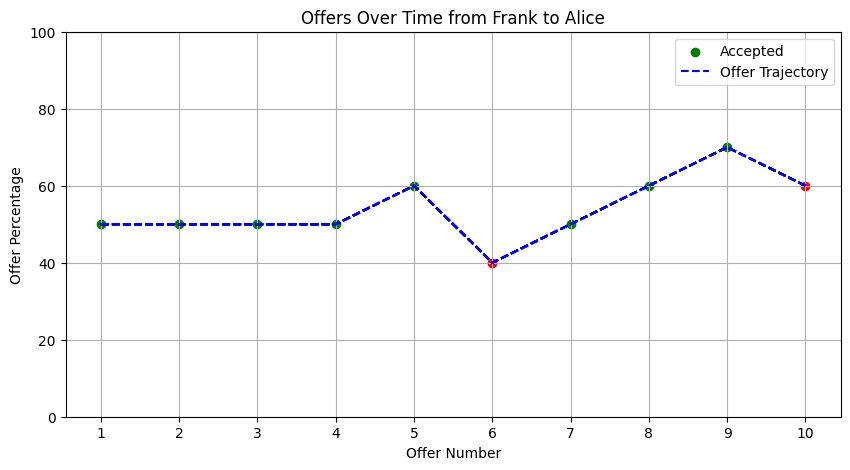

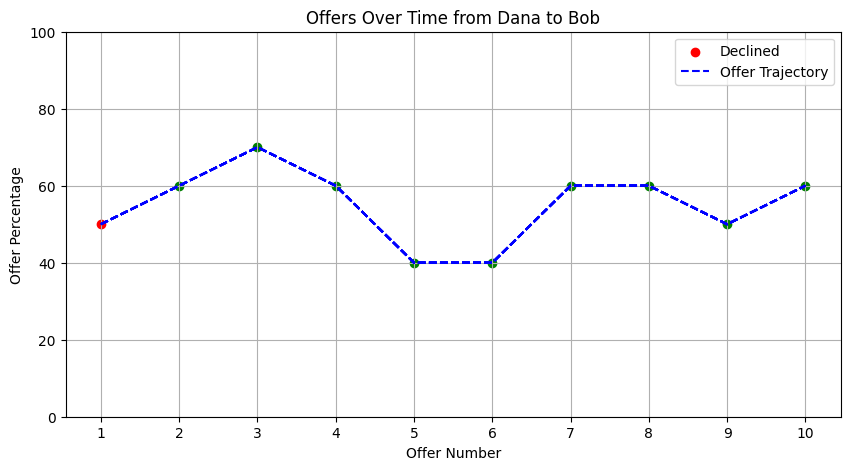

In [182]:
plot_offers_over_time(df_results1)

## Save results

In [183]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=3500, max_tokens=3500, terminators=())
print(episode_summary)

len(detailed_story):  2341


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=3500, max_tokens=3500, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [ ]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [ ]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Ultimate game experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [ ]:
display.HTML(tabbed_html)

#Interact with a specific player

In [ ]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [ ]:
utterence_from_user = 'Did you manage to sell any magic beans?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)